In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as io
import scipy.signal as signal
import scipy.fft as fft
import sys
sys.path.append("tools")
from utils import extr2min

In [3]:
mpl.rcParams['xtick.labelsize'] = 20;
mpl.rcParams['ytick.labelsize'] = 20;
mpl.rcParams['axes.titlesize'] = 25;
plt.rc('axes', labelsize=22.5);
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = True;
sapin = (0.15, 0.39, 0.10)

## Gravitational wave

Model from Newtonian approximation of general relativity
$$
s(t) = A(t_0 - t)^{-1/4} \cos(d(t_0-t)^{5/8}+\varphi)\boldsymbol{1}_{(-\infty; t_0[}(t).
$$
Physical information 
- chirp mass $\mathcal{M}$
- time of colapse $t_0$
contained in the constants $A$ and $d$.

Text(0, 0.5, 'Strain [a.u.]')

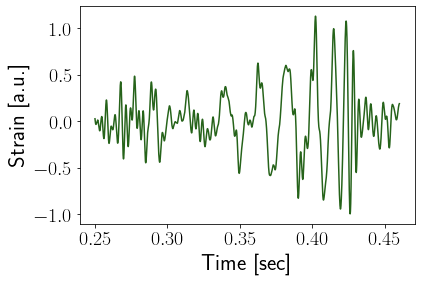

In [4]:
data   = io.loadmat('data/gw.mat')
t_obs  = data['t_obs']
t_obs  = np.reshape(t_obs, (t_obs.shape[0],))
gw     = data['s_obs']
gw     = np.reshape(gw, (gw.shape[0],))

plt.plot(t_obs,gw,color=sapin)
plt.xlabel('Time [sec]')
plt.ylabel('Strain [a.u.]')

## Fourier analysis

The frequency content of a signal is computed from its Fourier transform defined as

$$
\mathcal{F}x(\omega) = \int_{\mathbb{R}} \overline{x(t)} \exp(-\mathrm{i}\omega t)\, \mathrm{d}t.
$$

Text(0, 0.5, '$| \\mathcal{F}y |$ [a.u.]')

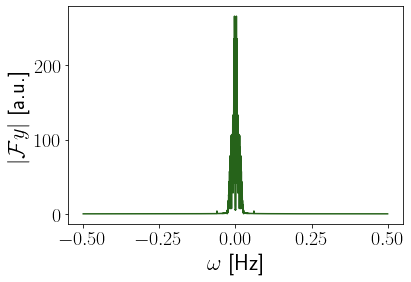

In [5]:
N = t_obs.shape[0]

# Fourier analysis
Fgw       = fft.fft(gw)
freq      = fft.fftfreq(N)

# Remap the frequencies
Fgw       = fft.fftshift(Fgw)
freq      = fft.fftshift(freq)


plt.plot(freq,np.abs(Fgw),color=sapin)
plt.xlabel(r'$\omega$ [Hz]')
plt.ylabel('$| \mathcal{F}y |$ [a.u.]')

## Time-frequency analysis

Text(0.5, 0, '$t$ [sec]')

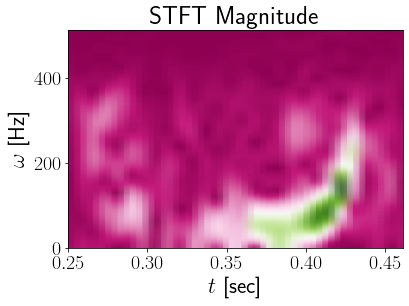

In [7]:
Nfft = 2**15
Nwin = 2**8

# Gaussian window of unit energy
g        = signal.gaussian(Nwin, np.sqrt((Nfft)/2/np.pi))
g        = g/g.sum()

# Compute the Gaussian Short-Time Fourier Transform
dt = t_obs[1]-t_obs[0]
f, t, Zgw = signal.stft(gw, fs = 1/dt, window = g, nperseg = Nwin, nfft = Nfft)


# Select the region of interest in the time-frequency plane
flim  = 2**10
t_int = t + t_obs[0]
f_int = f[0:flim]
Z_int = Zgw[0:flim,:]


# Display the spectrogram magnitude
plt.pcolormesh(t_int, f_int, np.abs(Z_int), shading='gouraud', cmap = 'PiYG')
plt.title('STFT Magnitude')
plt.ylabel(r'$\omega$ [Hz]')
plt.xlabel('$t$ [sec]')

## Signal processing in the time-frequency plane

Text(0.5, 0, '$t$ [sec]')

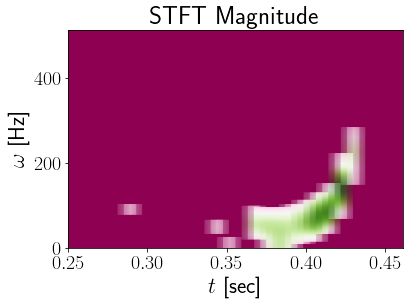

In [8]:
# Thresholding of the spectrogram
th         = 0.35        # choose a percentage of the max
Sgw        = np.abs(Zgw) # magnitude of the STFT
mask       = Sgw >= th*Sgw.max() 
mask       = mask.astype(float)
Zgw_th     = Zgw*mask

Z_int_th = Zgw_th[0:flim,:]

# Display the threshold spectrogram magnitude
plt.pcolormesh(t_int, f_int, np.abs(Z_int_th), shading='gouraud', cmap = 'PiYG')
plt.title('STFT Magnitude')
plt.ylabel(r'$\omega$ [Hz]')
plt.xlabel('$t$ [sec]')

Text(0.5, 0, '$t$ [sec]')

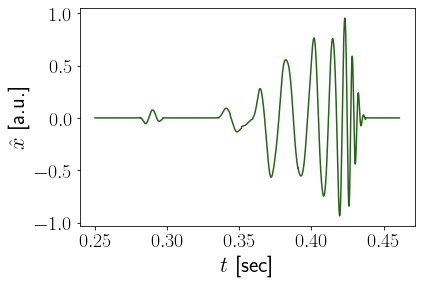

In [11]:
# Inverse Shirt-Time Fourier Transform
t, Rgw = signal.istft(Zgw_th, fs = 1/dt, window = g, nperseg = Nwin, nfft = Nfft)

# Correct time interval
Rt     = t + t_obs[0]

# Display the reconstructed signal
plt.plot(Rt, Rgw.real, color=(0.15, 0.39, 0.10))
plt.ylabel(r'$\hat{x}$ [a.u.]')
plt.xlabel('$t$ [sec]')

Text(0.5, 0, '$t$ [sec]')

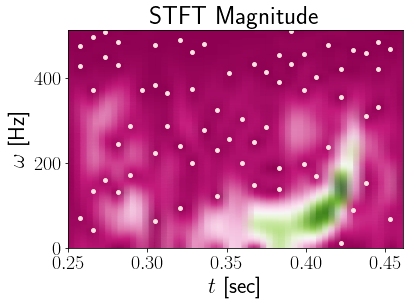

In [12]:
# Find the zeros
zx, zy    = extr2min(np.abs(Z_int))

# Display the spectrogram and its zeros
plt.pcolormesh(t_int, f_int, np.abs(Z_int), shading='gouraud', cmap = 'PiYG')
plt.scatter(t_int[zy],f_int[zx],s = 15,color = 'mistyrose')
plt.title('STFT Magnitude')
plt.ylabel(r'$\omega$ [Hz]')
plt.xlabel('$t$ [sec]')